In [1]:
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

In [2]:
def bandpass_filter(data, fs, lowcut=1, highcut=40, order=4):
    """
    Apply bandpass filter to multi-channel EEG data.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=-1)


def extract_segments_by_time(data, segment_len=1000, interval_sec=1.0, sampling_rate=250):
    """
    data: shape (N, 9)，前8列为通道数据，第9列为时间戳
    """
    signal = data[:, :8]
    timestamps = data[:, 8]

    # 保证数据按时间升序排列
    sorted_indices = np.argsort(timestamps)
    signal = signal[sorted_indices]
    timestamps = timestamps[sorted_indices]

    start_time = timestamps[0]
    max_index = len(timestamps) - segment_len
    i = 0
    current_idx = 0
    segments = []

    while current_idx + segment_len <= len(timestamps):
        target_time = start_time + i * interval_sec
        # 只在局部范围搜索（提高速度）
        search_range = range(max(current_idx - 10, 0), min(current_idx + 10, max_index))
        sub_indices = np.array(search_range)
        sub_times = timestamps[sub_indices]
        closest_sub_idx = sub_indices[np.argmin(np.abs(sub_times - target_time))]

        # 截取 segment_len 个点
        if closest_sub_idx + segment_len > len(timestamps):
            break
        segments.append(signal[closest_sub_idx : closest_sub_idx + segment_len])

        # 更新 current_idx（下一轮从附近开始找）
        current_idx = closest_sub_idx + sampling_rate
        i += 1

    segments = np.array(segments)
    segments_zero_mean = segments - np.mean(segments, axis=1, keepdims=True)
    segments_zero_mean = segments_zero_mean.reshape(-1, 8, 1000)
    # print(segments_zero_mean.shape)
    # return segments_zero_mean

    segments_filtered = np.empty_like(segments_zero_mean)

    for i in range(segments_zero_mean.shape[0]):
        segment = segments_zero_mean[i]  # shape: (8, 1000)
        # 对每个片段做 1–40 Hz 带通滤波
        filtered_segment = bandpass_filter(segment, fs=250, lowcut=1, highcut=40)
        segments_filtered[i] = filtered_segment

    print(segments_filtered.shape)

    return segments_filtered


In [3]:
for i in range(4):
    data = np.load("X"+str(i+1)+".npy")
    segments = extract_segments_by_time(data)
    np.save("X"+str(i+1)+"_stacked.npy", segments)

(1193, 8, 1000)
(1193, 8, 1000)
(1025, 8, 1000)
(1313, 8, 1000)


In [4]:
X1 = np.load(f"X1_stacked.npy")
X2 = np.load(f"X2_stacked.npy")
X3 = np.load(f"X3_stacked.npy")
X4 = np.load(f"X4_stacked.npy")
# X = np.concatenate([X1, X2, X3, X4], axis=0)
X = np.concatenate([X1[40:-20], X2[40:-20], X3[40:-20], X4[40:-20]], axis=0)
# mean = X.mean(axis=-1, keepdims=True)
# std = X.std(axis=-1, keepdims=True) + 1e-6
# X = (X - mean) / std
np.save("X.npy", X)

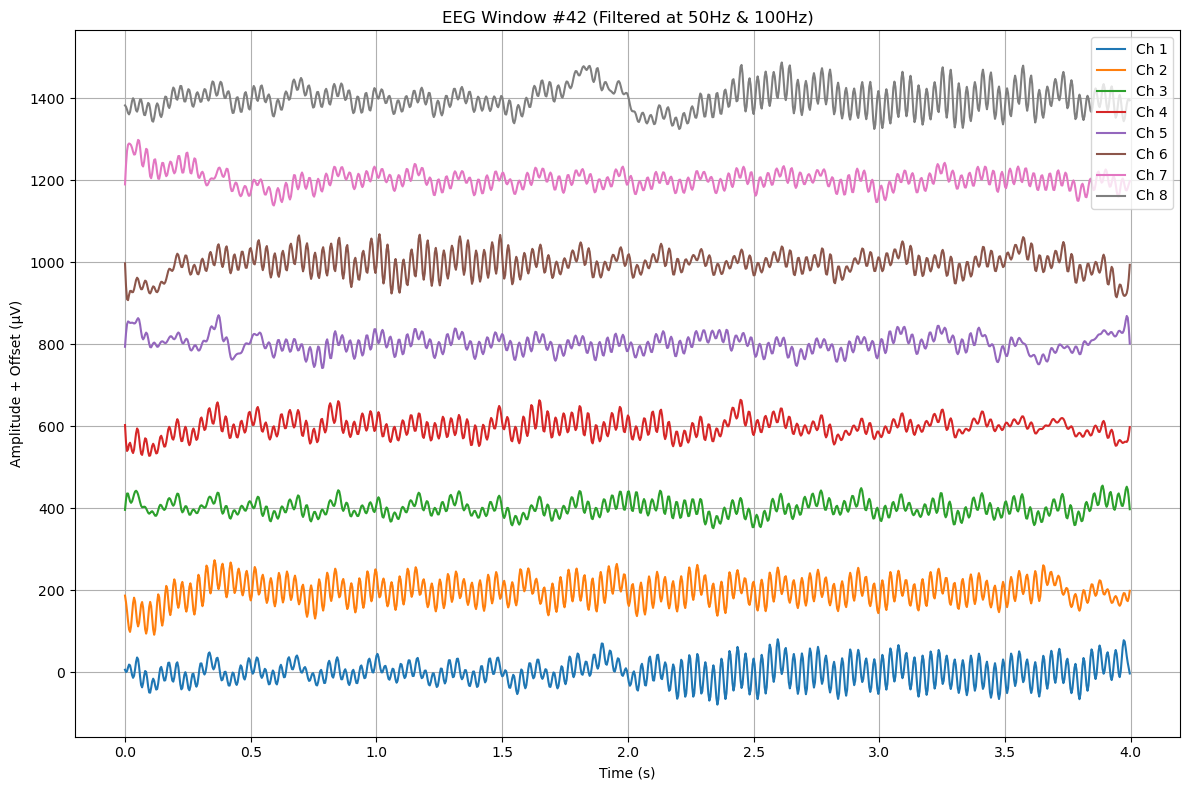

In [5]:
# 选择第0个窗口
window_index = 42
window_data = segments[window_index]  # shape: (8, 1000)
channels = window_data.shape[0]
time = np.arange(window_data.shape[1]) / 250  # 假设采样率为250Hz，转换为秒

# 创建图像
plt.figure(figsize=(12, 8))
for i in range(channels):
    plt.plot(time, window_data[i] + i * 200, label=f'Ch {i+1}')  # 向上平移避免重叠

plt.title(f'EEG Window #{window_index} (Filtered at 50Hz & 100Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude + Offset (μV)')
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()